### Import & Setup

In [1]:
import os
from pathlib import Path

import cv2
import numpy as np

from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print("✅ Libraries imported.")


✅ Libraries imported.


### Path

In [2]:
base_dir = Path("/kaggle/input/flowerdatasets/flowers")
train_dir = base_dir / "train"
val_dir   = base_dir / "val"
test_dir  = base_dir / "test"

class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
print("Classes:", class_names)

Classes: ['daisy', 'dandelion', 'lily', 'orchid', 'rose', 'sunflower', 'tulip']


### RootSIFT extractor

In [3]:
sift = cv2.SIFT_create()

def extract_rootsift_descriptors(img_gray, max_kp=500):
    """
    img_gray: ảnh grayscale (ndarray)
    """
    keypoints, desc = sift.detectAndCompute(img_gray, None)
    if desc is None:
        return None

    if desc.shape[0] > max_kp:
        desc = desc[:max_kp]
        
     # ======= RootSIFT =======
    desc = desc.astype("float32")
    # 1) L1 normalize từng descriptor
    desc /= (desc.sum(axis=1, keepdims=True) + 1e-7)
    # 2) Căn bậc hai từng phần tử
    desc = np.sqrt(desc)

    return desc

### Thu thập SIFT descriptor từ train & train codebook (BoVW)

In [4]:
def collect_descriptors_from_train(train_folder, max_images_per_class=250):
    all_desc = []
    train_folder = Path(train_folder)

    for cls in class_names:
        cls_dir = train_folder / cls
        img_files = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            img_files.extend(cls_dir.glob(ext))

        img_files = img_files[:max_images_per_class]
        print(f"[Collect] {cls}: {len(img_files)} images")
        
        for img_path in img_files:
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            img_gray = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2GRAY)
            desc = extract_rootsift_descriptors(img_gray)
            if desc is not None:
                all_desc.append(desc)

    if not all_desc:
        return None

    all_desc = np.vstack(all_desc)
    return all_desc


all_desc = collect_descriptors_from_train(train_dir, max_images_per_class=250)
print("All descriptors shape:", all_desc.shape)

[Collect] daisy: 250 images
[Collect] dandelion: 250 images
[Collect] lily: 250 images
[Collect] orchid: 250 images
[Collect] rose: 250 images
[Collect] sunflower: 250 images
[Collect] tulip: 250 images
All descriptors shape: (598336, 128)


In [ ]:
# Số "visual words"
K = 700

print(f"Training MiniBatchKMeans with K={K} ...")
kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=2000,
    n_init=10,
    random_state=42,
    verbose=1
)
kmeans.fit(all_desc)
print("Done.")

### Trích HSV histogram + BoVW cho 1 ảnh

In [6]:
def extract_hsv_hist(img_bgr, bins=(4,4,4)):
    """
    HSV 3D histogram (ít bins để tránh quá dài).
    Hellinger (L1 + sqrt).
    """
    img_resized = cv2.resize(img_bgr, (256, 256))
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)

    hist = cv2.calcHist(
        [hsv], [0,1,2], None,
        bins,                       # (H,S,V)
        [0,180, 0,256, 0,256]
    )
    hist = hist.astype("float32")
    hist = hist.flatten()

    # Hellinger cho màu
    hist /= (hist.sum() + 1e-7)
    hist = np.sqrt(hist)
    return hist

def extract_center_hsv_hist(img_bgr, bins=(4,4,4)):
    h, w = img_bgr.shape[:2]
    # cắt ô giữa ảnh (ví dụ 1/2 chiều cao, 1/2 chiều rộng)
    x1, x2 = w//4, 3*w//4
    y1, y2 = h//4, 3*h//4
    center = img_bgr[y1:y2, x1:x2]

    hsv = cv2.cvtColor(center, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv],[0,1,2],None,bins,[0,180,0,256,0,256])
    hist = hist.astype("float32").flatten()
    hist /= (hist.sum() + 1e-7)
    hist = np.sqrt(hist)   # Hellinger
    return hist


In [7]:
def image_to_bovw_hsv(img_path):
    """
    Trả về feature vector = [BoVW_RootSIFT, HSV_hist]
    """
    img = cv2.imread(str(img_path))
    if img is None:
        # fallback vector zeros
        return np.zeros(K + (4*4*4), dtype=np.float32)

    img_resized = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # --- BoVW từ RootSIFT ---
    desc = extract_rootsift_descriptors(gray)
    if desc is None:
        bovw_hist = np.zeros(K, dtype=np.float32)
    else:
        words = kmeans.predict(desc)
        bovw_hist, _ = np.histogram(words, bins=np.arange(K+1))
        bovw_hist = bovw_hist.astype("float32")
        # Hellinger
        bovw_hist /= (bovw_hist.sum() + 1e-7)
        bovw_hist = np.sqrt(bovw_hist)

    # --- HSV color feature ---
    global_hsv = extract_hsv_hist(img_resized, bins=(4,4,4))  # 64 dims
    center_hsv = extract_center_hsv_hist(img_resized, bins=(4,4,4))
    # --- Gộp ---
    feat = np.hstack([bovw_hist, global_hsv, center_hsv])
    return feat

### Load dataset (train / val / test) với BoVW+HSV

In [8]:
def load_bovw_hsv_dataset(folder):
    X, y = [], []
    folder = Path(folder)

    for label, cls in enumerate(class_names):
        cls_dir = folder / cls
        img_files = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            img_files.extend(cls_dir.glob(ext))

        print(f"[Load] {folder.name} - {cls}: {len(img_files)} images")

        for img_path in img_files:
            feat = image_to_bovw_hsv(img_path)
            X.append(feat)
            y.append(label)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

X_train, y_train = load_bovw_hsv_dataset(train_dir)
X_val,   y_val   = load_bovw_hsv_dataset(val_dir)
X_test,  y_test  = load_bovw_hsv_dataset(test_dir)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)


[Load] train - daisy: 1231 images
[Load] train - dandelion: 1046 images
[Load] train - lily: 1132 images
[Load] train - orchid: 1295 images
[Load] train - rose: 1042 images
[Load] train - sunflower: 1199 images
[Load] train - tulip: 1124 images
[Load] val - daisy: 352 images
[Load] val - dandelion: 299 images
[Load] val - lily: 324 images
[Load] val - orchid: 370 images
[Load] val - rose: 298 images
[Load] val - sunflower: 342 images
[Load] val - tulip: 321 images
[Load] test - daisy: 176 images
[Load] test - dandelion: 150 images
[Load] test - lily: 162 images
[Load] test - orchid: 186 images
[Load] test - rose: 149 images
[Load] test - sunflower: 172 images
[Load] test - tulip: 161 images
Train: (8069, 828) (8069,)
Val  : (2306, 828) (2306,)
Test : (1156, 828) (1156,)


### Chuẩn hóa + PCA

In [9]:
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Applying PCA...")
pca = PCA(n_components=192, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Original dim:", X_train_scaled.shape[1])
print("After PCA   :", X_train_pca.shape[1])


Standardizing features...
Applying PCA...
Original dim: 828
After PCA   : 192


### Train SVM 

In [10]:
C_list = [1, 10, 100]
gamma_list = ["scale", 1/256, 1/192]
kernel_list = ["rbf"]

best_model = None
best_params = None
best_val_acc = 0.0

print("===== GRID SEARCH SVM (BoVW + HSV) =====")

for C in C_list:
    for gamma in gamma_list:
        for kernel in kernel_list:
            print(f"Đang thử SVM(C={C}, gamma={gamma}, kernel={kernel}) ...")
            
            clf = SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)

            # ✅ Train trên train
            clf.fit(X_train_pca, y_train)

            # ✅ Đánh giá trên validation
            val_pred = clf.predict(X_val_pca)
            val_acc = accuracy_score(y_val, val_pred)
            print(f"  --> Val accuracy = {val_acc:.4f}")
            
            # Cập nhật best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = clf
                best_params = {"C": C, "gamma": gamma, "kernel": kernel}

print("\n===== KẾT QUẢ TỐT NHẤT TRÊN VALIDATION =====")
print("Best params:", best_params)
print("Best val accuracy:", best_val_acc)


===== GRID SEARCH SVM (BoVW + HSV) =====
Đang thử SVM(C=1, gamma=scale, kernel=rbf) ...
  --> Val accuracy = 0.8712
Đang thử SVM(C=1, gamma=0.00390625, kernel=rbf) ...
  --> Val accuracy = 0.8729
Đang thử SVM(C=1, gamma=0.005208333333333333, kernel=rbf) ...
  --> Val accuracy = 0.8643
Đang thử SVM(C=10, gamma=scale, kernel=rbf) ...
  --> Val accuracy = 0.8768
Đang thử SVM(C=10, gamma=0.00390625, kernel=rbf) ...
  --> Val accuracy = 0.8781
Đang thử SVM(C=10, gamma=0.005208333333333333, kernel=rbf) ...
  --> Val accuracy = 0.8725
Đang thử SVM(C=100, gamma=scale, kernel=rbf) ...
  --> Val accuracy = 0.8768
Đang thử SVM(C=100, gamma=0.00390625, kernel=rbf) ...
  --> Val accuracy = 0.8781
Đang thử SVM(C=100, gamma=0.005208333333333333, kernel=rbf) ...
  --> Val accuracy = 0.8725

===== KẾT QUẢ TỐT NHẤT TRÊN VALIDATION =====
Best params: {'C': 10, 'gamma': 0.00390625, 'kernel': 'rbf'}
Best val accuracy: 0.8781439722463139


In [11]:
# Gộp train và val để train lại với bộ tham số tốt nhất vừa tìm được
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled       = scaler.transform(X_test)

X_train_full_pca = pca.fit_transform(X_train_full_scaled)
X_test_pca       = pca.transform(X_test_scaled)

svm_final = SVC(C=10, gamma=1/256, kernel='rbf', random_state=42)
svm_final.fit(X_train_full_pca, y_train_full)

SVC(C=10, gamma=0.00390625, random_state=42)

### Đánh giá 

===== ĐÁNH GIÁ TRÊN TEST SET =====
Test accuracy: 0.8711072664359861

Classification report:
              precision    recall  f1-score   support

       daisy       0.97      0.92      0.94       176
   dandelion       0.97      0.93      0.95       150
        lily       0.83      0.88      0.86       162
      orchid       0.84      0.88      0.86       186
        rose       0.78      0.75      0.77       149
   sunflower       0.92      0.98      0.95       172
       tulip       0.78      0.75      0.76       161

    accuracy                           0.87      1156
   macro avg       0.87      0.87      0.87      1156
weighted avg       0.87      0.87      0.87      1156



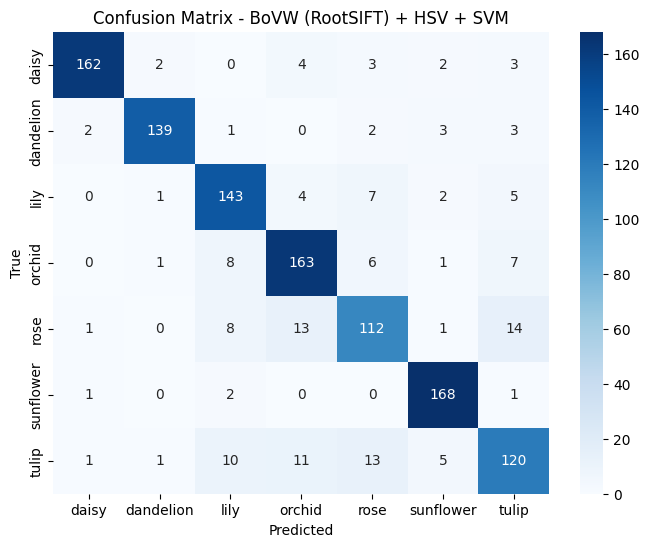

In [12]:
# Test set
test_pred = svm_final.predict(X_test_pca)
test_acc = accuracy_score(y_test, test_pred)
print("===== ĐÁNH GIÁ TRÊN TEST SET =====")
print("Test accuracy:", test_acc)
print("\nClassification report:")
print(classification_report(y_test, test_pred, target_names=class_names))

cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BoVW (RootSIFT) + HSV + SVM")
plt.show()

### Dự đoán với một ảnh bất kì

In [13]:
def predict_image(img_path: str):
    feats = image_to_bovw_hsv(img_path)
    feats = feats.reshape(1, -1)
    feats_scaled = scaler.transform(feats)
    feats_pca = pca.transform(feats_scaled)
    pred_idx = svm_final.predict(feats_pca)[0]
    return class_names[pred_idx]

# Ví dụ lấy 1 ảnh bất kỳ từ test set
sample_img_path = '/kaggle/input/test-demo/image42-1660292012-557-width2048height1560.jpg'
print("Sample image:", sample_img_path)

print("Predicted:", predict_image(str(sample_img_path)))

Sample image: /kaggle/input/test-demo/image42-1660292012-557-width2048height1560.jpg
Predicted: tulip


### Lưu file model

In [15]:
class FlowerPipeline:
    def __init__(self, kmeans, scaler, pca, svm, class_names):
        self.kmeans = kmeans
        self.scaler = scaler
        self.pca = pca
        self.svm = svm
        self.class_names = class_names
        self.sift = None   # placeholder
    
    def _init_sift(self):
        if self.sift is None:
            self.sift = cv2.SIFT_create()

    # ---------------------- RootSIFT ----------------------
    def extract_rootsift_descriptors(self, img_gray, max_kp=500):
        """
        img_gray: ảnh grayscale (ndarray)
        """
        self._init_sift()
        
        keypoints, desc = self.sift.detectAndCompute(img_gray, None)
        if desc is None:
            return None
    
        if desc.shape[0] > max_kp:
            desc = desc[:max_kp]
            
         # ======= RootSIFT =======
        desc = desc.astype("float32")
        # 1) L1 normalize từng descriptor
        desc /= (desc.sum(axis=1, keepdims=True) + 1e-7)
        # 2) Căn bậc hai từng phần tử
        desc = np.sqrt(desc)
    
        return desc

    # ---------------------- HSV histogram ----------------------
    def extract_hsv_hist(self, img_bgr, bins=(4,4,4)):
        """
        HSV 3D histogram (ít bins để tránh quá dài).
        Hellinger (L1 + sqrt).
        """
        img_resized = cv2.resize(img_bgr, (256, 256))
        hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    
        hist = cv2.calcHist(
            [hsv], [0,1,2], None,
            bins,                       # (H,S,V)
            [0,180, 0,256, 0,256]
        )
        hist = hist.astype("float32")
        hist = hist.flatten()
    
        # Hellinger cho màu
        hist /= (hist.sum() + 1e-7)
        hist = np.sqrt(hist)
        return hist

    def extract_center_hsv_hist(self, img_bgr, bins=(4,4,4)):
        h, w = img_bgr.shape[:2]
        # cắt ô giữa ảnh (ví dụ 1/2 chiều cao, 1/2 chiều rộng)
        x1, x2 = w//4, 3*w//4
        y1, y2 = h//4, 3*h//4
        center = img_bgr[y1:y2, x1:x2]
    
        hsv = cv2.cvtColor(center, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv],[0,1,2],None,bins,[0,180,0,256,0,256])
        hist = hist.astype("float32").flatten()
        hist /= (hist.sum() + 1e-7)
        hist = np.sqrt(hist)   # Hellinger
        return hist

    # ---------------------- Build feature BoVW + HSV ----------------------
    def image_to_bovw_hsv(self, img_path, K):
        """
        Trả về feature vector = [BoVW_RootSIFT, HSV_hist]
        """
        img = cv2.imread(str(img_path))
        if img is None:
            # fallback vector zeros
            return np.zeros(K + (4*4*4), dtype=np.float32)
    
        img_resized = cv2.resize(img, (256, 256))
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
        # --- BoVW từ RootSIFT ---
        desc = self.extract_rootsift_descriptors(gray)
        if desc is None:
            bovw_hist = np.zeros(K, dtype=np.float32)
        else:
            words = self.kmeans.predict(desc)
            bovw_hist, _ = np.histogram(words, bins=np.arange(K+1))
            bovw_hist = bovw_hist.astype("float32")
            # Hellinger
            bovw_hist /= (bovw_hist.sum() + 1e-7)
            bovw_hist = np.sqrt(bovw_hist)
    
        # --- HSV color feature ---
        global_hsv = self.extract_hsv_hist(img_resized, bins=(4,4,4))  # 64 dims
        center_hsv = self.extract_center_hsv_hist(img_resized, bins=(4,4,4))
        # --- Gộp ---
        feat = np.hstack([bovw_hist, global_hsv, center_hsv])
        return feat

    # ---------------------- Predict ----------------------
    def predict(self, img_path):
        K = self.kmeans.n_clusters

        feat = self.image_to_bovw_hsv(img_path, K)
        feat_scaled = self.scaler.transform([feat])
        feat_pca = self.pca.transform(feat_scaled)

        pred = self.svm.predict(feat_pca)[0]
        return self.class_names[pred]

pipeline = FlowerPipeline(
    kmeans = kmeans,
    scaler = scaler,
    pca = pca,
    svm = svm_final,
    class_names = class_names
)

with open("bovw_sift_hsv_svm.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("Saved pipeline!")

pipeline = pickle.load(open("bovw_sift_hsv_svm.pkl","rb"))

pipeline.predict("/kaggle/input/test-demo/image42-1660292012-557-width2048height1560.jpg")

Saved pipeline!


'tulip'